In [32]:
#!/usr/bin/env python
# coding: utf-8

#%%[markdown]
# # Sentiment prediction from Amazon reviews

# ## About DataSet

# This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
# 
# Contents
# 
# database.csv: Contains the table 'Reviews'
# 
# Data includes:
# 
# Reviews from Oct 1999 - Oct 2012 568,454 reviews 256,059 users 74,258 products 260 users with > 50 reviews

In [33]:
import sys
import os

# Getting the current script's directory
current_dir = os.path.dirname(os.path.abspath(__file__))

# Adding the parent directory to the Python path
sys.path.append(os.path.dirname(current_dir))

In [34]:
#Importing Libraries

import sys 
import sqlite3
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import warnings
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pickle
import gensim
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from data_preprocessing import clean_text, preprocess_text, sentence_to_words
from ml_algorithms.KNN import KNN_train_simple_cv
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

In [35]:
raw_data = pd.read_csv("C:\Anand\Projects_GWU\Sentiment-prediction-from-Amazon-reviews\data\Reviews.csv")

In [36]:
raw_data.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [37]:
print(raw_data["Text"].head(10))

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object


In [38]:
raw_data.shape

(568454, 10)

In [39]:
# Drop rows with rating/score as 3.
value_to_drop = 3

# Drop rows where 'Score' has value 3.
raw_data = raw_data[raw_data['Score'] != value_to_drop]

In [40]:
# After dropping row with score 3
print(raw_data.shape)

#Unique values in Score column must be 1/2/4/5.
print(raw_data.Score.unique())

(525814, 10)
[5 1 4 2]


In [41]:
# Giving 4&5 as Positive and 1&2 as Negative Rating 
def assign_values(value):
    if value < 3:
        return 'Negative'
    else:
        return 'Positive'

raw_data['Review'] = raw_data['Score'].apply(assign_values)

In [42]:
raw_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [43]:
# Checking for duplicate Reviews 
boolean = not raw_data["Text"].is_unique      
boolean = raw_data['Text'].duplicated().any()
print(boolean)

True


In [44]:
# Drop duplicated Reviews
raw_data = raw_data.drop_duplicates(subset='Text', keep='first')

# Check the shape
print(raw_data.shape)

(363836, 11)


In [45]:
# Check if HelpfulnessNumerator is less than HelpfulnessDenominator, If so then drop those rows
raw_data=raw_data[raw_data.HelpfulnessNumerator<=raw_data.HelpfulnessDenominator]
print(raw_data.shape)

# The observations in the dataset dropped from 568454 to 363834 as there were a lot of Duplicate Reviews and Number of people who found review helpful cannot be greater than number of people who viewed the review. These rows were dropped

# # Check proportions of categories in output label:
# raw_data['Review'].value_counts()

(363834, 11)


In [46]:
# Apply clean_text function to clean the text column.
raw_data['Clean_Text'] = raw_data['Text'].apply(lambda x: clean_text(x))

In [47]:
print(raw_data["Text"].head(10))

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object


In [48]:
# Apply text preprocessing to the 'Text' column from data-preprocessing.py file 
raw_data['Clean_Text'] = raw_data['Clean_Text'].apply(preprocess_text)

In [49]:
# Comparing the Original Text and the processed text
print(raw_data["Text"][1])

print("\n After Processing of Text \n")

print(raw_data["Clean_Text"][1])

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

 After Processing of Text 

product arriv label jumbo salt peanutsth peanut actual small size unsalt not sure error vendor intend repres product jumbo


In [50]:
# Converting sentence into words using sentence_to_words function from the data_preprocessing file
list_of_words_in_sentance = sentence_to_words(raw_data, 'Clean_Text')

In [51]:
raw_data["Clean_Text"].iloc[0]

'bought sever vital can dog food product found good qualiti the product look like stew process meat smell better labrador finicki appreci product better'

In [52]:
print(raw_data['Clean_Text'])

0         bought sever vital can dog food product found ...
1         product arriv label jumbo salt peanutsth peanu...
2         this confect around centuri light pillowi citr...
3         look secret ingredi robitussin believ found go...
4         great taffi great price there wide assort yumm...
                                ...                        
568449    great sesam chickenthi good better restur eate...
568450    disappoint flavor the chocol note especi weak ...
568451    these star small give one train session tri tr...
568452    these best treat train reward dog good groom l...
568453    satisfi product advertis use cereal raw vinega...
Name: Clean_Text, Length: 363834, dtype: object


In [53]:
print(f"Sentence cleaned: {raw_data['Clean_Text'].values[0]}")
print(f"Words in cleaned sentence{list_of_words_in_sentance[0]}")

Sentence cleaned: bought sever vital can dog food product found good qualiti the product look like stew process meat smell better labrador finicki appreci product better
Words in cleaned sentence['bought', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'the', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', 'better']


 Time Based Splitting

In [54]:
final_reviews = raw_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(363834, 12)

In [55]:
# Label Encoding Reviews Column
label_encoder = LabelEncoder()

# Fit and transform the "Review" column
raw_data['Review'] = label_encoder.fit_transform(raw_data['Review'])

 Train and Test Split

In [56]:
# Splitting data into train, Train and Test 
X = raw_data['Clean_Text']
Y = raw_data['Review']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.20, random_state=123)

print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)

X_train, Y_train (291067,) (291067,)
X_test, Y_test (72767,) (72767,)


# Bag of Words

In [57]:
# Bag Of Words
Count_vectorizer = CountVectorizer()
X_train_bow = Count_vectorizer.fit_transform(X_train.values)
print(f"Shape of dataset after converting into BOW is {X_train_bow.get_shape()}")
X_test_bow = Count_vectorizer.transform(X_test.values)  # Use transform instead of fit_transform
print(f"Shape of dataset after converting into BOW is {X_test_bow.get_shape()}")

Shape of dataset after converting into BOW is (291067, 164404)
Shape of dataset after converting into BOW is (72767, 164404)


In [58]:
# Normalize BOW Train and Test Data
X_train_bow=preprocessing.normalize(X_train_bow)
X_test_bow=preprocessing.normalize(X_test_bow)
print("The shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("Test Data Size: ",X_test_bow.shape)

The shape of out text BOW vectorizer  (291067, 164404)
Test Data Size:  (72767, 164404)


# Uni, Bi and Tri Grams

In [59]:
Count_vectorizer_n_grams = CountVectorizer(ngram_range=(1,3) ) 
X_train_n_grams = Count_vectorizer_n_grams.fit_transform(X_train.values)
print("Shape of dataset after converting into uni, bi and tri-grams is ",X_train_n_grams.get_shape())
X_test_n_grams = Count_vectorizer_n_grams.transform(X_test.values)
print("Shape of dataset after converting into uni, bi and tri-grams is ",X_test_n_grams.get_shape())

Shape of dataset after converting into uni, bi and tri-grams is  (291067, 11238235)
Shape of dataset after converting into uni, bi and tri-grams is  (72767, 11238235)


# Tf-Idf Vectorization

In [60]:
# tf-idf Vectorizer
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train_tf_idf_vectorizer = tf_idf_vectorizer.fit_transform(X_train.values)
X_test_tf_idf_vectorizer = tf_idf_vectorizer.transform(X_test.values)

print("Shape of dataset after converting into tf-idf is ", X_train_tf_idf_vectorizer.get_shape())
print("Shape of dataset after converting into tf-idf is ", X_test_tf_idf_vectorizer.get_shape())

Shape of dataset after converting into tf-idf is  (291067, 2916174)
Shape of dataset after converting into tf-idf is  (72767, 2916174)


In [61]:
# Normalize Tf-Idf Train and Test Data
X_train_tfidf=preprocessing.normalize(X_train_tf_idf_vectorizer)
X_test_tfidf=preprocessing.normalize(X_test_tf_idf_vectorizer)
print("The shape of out text BOW vectorizer ",X_train_tfidf.get_shape())
print("Test Data Size: ",X_test_tfidf.shape)

The shape of out text BOW vectorizer  (291067, 2916174)
Test Data Size:  (72767, 2916174)


# word2vec Model
 Making word2vec model using our data set and the same model will be used further.

In [62]:
# Training word2vec model on our own data.
w2v_model=gensim.models.Word2Vec(list_of_words_in_sentance,min_count=5, workers=4) 

In [63]:
# Saving the vocabolary of words in our trained word2vec model
w2v_vocab = list(w2v_model.wv.key_to_index)

In [64]:
# Get the top 10 words most similar words to "quality"
w2v_model.wv.most_similar('good')

[('great', 0.7597932815551758),
 ('decent', 0.7280157804489136),
 ('awesom', 0.6288422346115112),
 ('excel', 0.6277579665184021),
 ('fantast', 0.626093864440918),
 ('bad', 0.6003758907318115),
 ('goodit', 0.5922289490699768),
 ('nice', 0.5899881720542908),
 ('tasti', 0.581486165523529),
 ('goodth', 0.5711088180541992)]

In [65]:
raw_data.shape[0]

363834

# Average word2vec

In [66]:
sent_vectors_avg_word2vec = []; # The avg-w2v for each sentence/review is stored in this list
vector_size = len(w2v_model.wv['good']) 

for sent in tqdm(list_of_words_in_sentance): # Iterating over each review/sentence
    sent_vec = np.zeros(vector_size) 
    cnt_words =0; 
    for word in sent: # Iterating over each word in a review/sentence
        if word in w2v_vocab:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_avg_word2vec.append(sent_vec)
print(len(sent_vectors_avg_word2vec))

100%|██████████| 363834/363834 [07:02<00:00, 860.72it/s] 

363834


In [67]:
X_train_avg_wor2vec, X_test_avg_wor2vec, Y_train_avg_wor2vec, Y_test_avg_wor2vec = train_test_split(sent_vectors_avg_word2vec,Y, test_size=.20, random_state=0)
X_train_avg_wor2vec=preprocessing.normalize(X_train_avg_wor2vec)
X_test_avg_wor2vec=preprocessing.normalize(X_test_avg_wor2vec)
print(X_train_avg_wor2vec.shape)
print(X_test_avg_wor2vec.shape)

(291067, 100)
(72767, 100)


# Tf-Idf Wword2vec

In [68]:
tfidf_model = TfidfVectorizer()
tf_idf_matrix = tfidf_model.fit_transform(raw_data['Clean_Text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_words_in_sentance): # for each review/sentence 
    sent_vec = np.zeros(vector_size) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_vocab:
            vec = w2v_model.wv[word]
            #  tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X_train_tfidf_word2vec, X_test_tfidf_word2vec, Y_train_tfidf_wor2vec, Y_test_tfidf_wor2vec = train_test_split(tfidf_sent_vectors, Y, test_size=0.20,random_state=0)
X_train_tfidf_word2vec=preprocessing.normalize(X_train_tfidf_word2vec)
X_test_tfidf_word2vec=preprocessing.normalize(X_test_tfidf_word2vec)
print(X_train_tfidf_word2vec.shape)
print(X_test_tfidf_word2vec.shape)

100%|██████████| 363834/363834 [09:26<00:00, 642.19it/s] 


(291067, 100)
(72767, 100)


1 - AUC Score (CV): 0.506192924060669  Accuracy (CV): 0.8457518245135498
3 - AUC Score (CV): 0.6813108797457154  Accuracy (CV): 0.8539452177443703
5 - AUC Score (CV): 0.7338030492993182  Accuracy (CV): 0.8592756082579409
7 - AUC Score (CV): 0.760988579880904  Accuracy (CV): 0.8618783380008953
9 - AUC Score (CV): 0.7796742513617106  Accuracy (CV): 0.8619303925957544
11 - AUC Score (CV): 0.791187755906192  Accuracy (CV): 0.8617534069732335
13 - AUC Score (CV): 0.8021695549858443  Accuracy (CV): 0.8612953265384735
15 - AUC Score (CV): 0.810634665361802  Accuracy (CV): 0.8610246426452063
17 - AUC Score (CV): 0.8168061120825183  Accuracy (CV): 0.8609517662124035
19 - AUC Score (CV): 0.8221459856583814  Accuracy (CV): 0.8611183409159526
21 - AUC Score (CV): 0.8271655297701619  Accuracy (CV): 0.8606810823191363
23 - AUC Score (CV): 0.8302029376574929  Accuracy (CV): 0.8603271110740945
Best k-value based on AUC: 23
Best accuracy: 0.8619303925957544


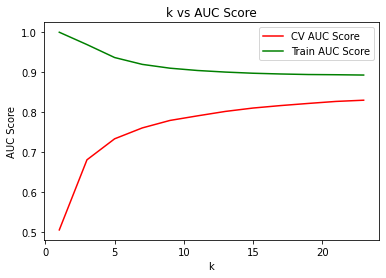

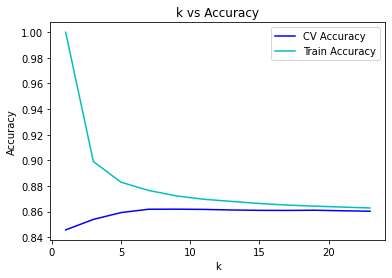

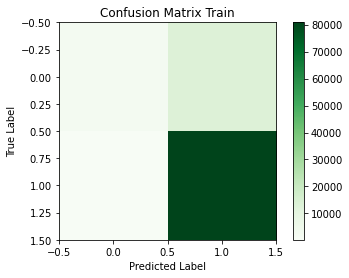

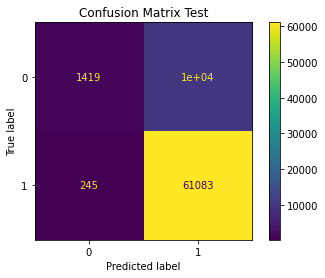

561951    1
384143    1
467741    1
120796    1
160889    1
         ..
442737    1
54066     0
287219    1
179156    1
140142    1
Name: Review, Length: 72767, dtype: int32 

[0.7826087  1.         0.82608696 ... 1.         0.91304348 0.82608696] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.8324394868644662
Accuracy (Test): 0.8589333076806794


In [69]:
auc_score_tf_idf_test, accuracy_tf_idf_test = KNN_train_simple_cv(X_train_tfidf, Y_train, X_test_tfidf, Y_test)

# print(f"AUC Score (Test): {auc_score_tf_idf_test}")
# print(f"Accuracy (Test): {accuracy_tf_idf_test}")

1 - AUC Score (CV): 0.5438311005256404  Accuracy (CV): 0.8359447388420976
3 - AUC Score (CV): 0.6997715749275878  Accuracy (CV): 0.8537578212028776
5 - AUC Score (CV): 0.7538736138112808  Accuracy (CV): 0.8595358812322363
7 - AUC Score (CV): 0.7808526333453252  Accuracy (CV): 0.8613994357281918
9 - AUC Score (CV): 0.7960000529291101  Accuracy (CV): 0.862242720164909
11 - AUC Score (CV): 0.8064062294117861  Accuracy (CV): 0.862357240273599
13 - AUC Score (CV): 0.8148472085001424  Accuracy (CV): 0.8621177891372471
15 - AUC Score (CV): 0.821358463022291  Accuracy (CV): 0.8616805305404308
17 - AUC Score (CV): 0.8261622379381479  Accuracy (CV): 0.8617325851352899
19 - AUC Score (CV): 0.8298924451304371  Accuracy (CV): 0.861722174216318
21 - AUC Score (CV): 0.8335894415455422  Accuracy (CV): 0.8610766972400654
23 - AUC Score (CV): 0.8358926597416443  Accuracy (CV): 0.8607643696709109
Best k-value based on AUC: 23
Best accuracy: 0.862357240273599


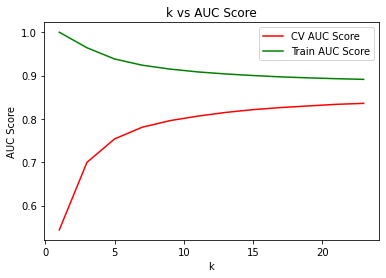

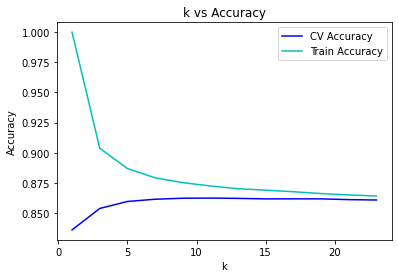

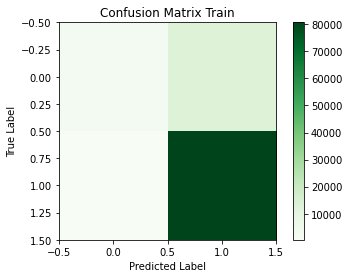

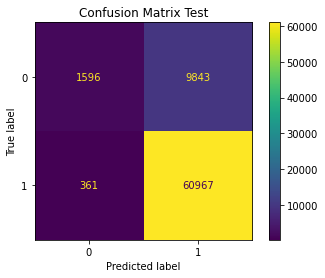

561951    1
384143    1
467741    1
120796    1
160889    1
         ..
442737    1
54066     0
287219    1
179156    1
140142    1
Name: Review, Length: 72767, dtype: int32 

[0.7826087  0.95652174 0.82608696 ... 0.95652174 1.         0.60869565] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.840178893336761
Accuracy (Test): 0.8597715997636292


In [70]:
auc_score_bow_test, accuracy_bow_test = KNN_train_simple_cv(X_train_bow, Y_train, X_test_bow, Y_test)

In [75]:
#Importing Libraries

import sys 
import sqlite3
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import warnings
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pickle
import gensim
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from data_preprocessing import clean_text, preprocess_text, sentence_to_words
from ml_algorithms.KNN import KNN_train_simple_cv
from ml_algorithms.NaiveBayes import NaiveBayes_train_simple_cv
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

 NaiveBayes on Bag of Words

AUC Score (CV): 0.8787373743329031  Accuracy (CV): 0.8440027901262844
AUC Score (Train): 0.8867622336918933  Accuracy (Train): 0.8430830607033342


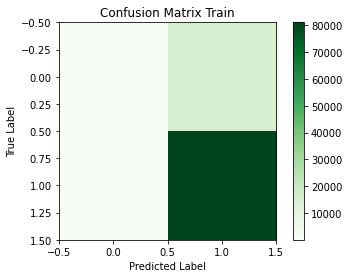

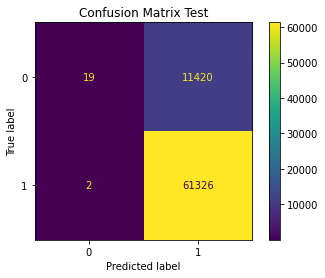

561951    1
384143    1
467741    1
120796    1
160889    1
         ..
442737    1
54066     0
287219    1
179156    1
140142    1
Name: Review, Length: 72767, dtype: int32 

[0.99407388 0.99785611 0.99002019 ... 0.99897318 0.9822145  0.97434954] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.8800382734908452
Accuracy (Test): 0.8430332430909616


In [76]:
auc_score_bow_test_NB, accuracy_bow_test_NB = NaiveBayes_train_simple_cv(X_train_bow, Y_train, X_test_bow, Y_test)

AUC Score (CV): 0.8294365091094146  Accuracy (CV): 0.8440340228832
AUC Score (Train): 0.9054657123267376  Accuracy (Train): 0.8429394812680115


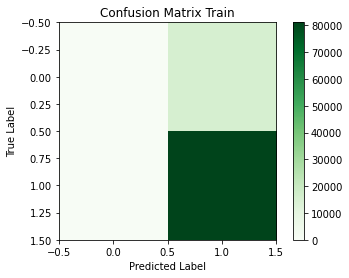

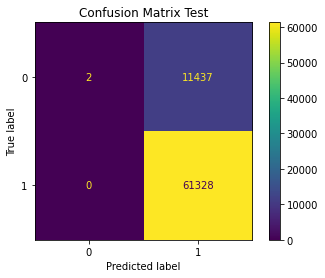

561951    1
384143    1
467741    1
120796    1
160889    1
         ..
442737    1
54066     0
287219    1
179156    1
140142    1
Name: Review, Length: 72767, dtype: int32 

[0.99979794 0.99979334 0.99984494 ... 0.99999178 0.99828703 0.99742323] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.8204978946960051
Accuracy (Test): 0.8428271056935149


In [77]:
auc_score_tf_idf_test_NB, accuracy_tf_idf_test_NB = NaiveBayes_train_simple_cv(X_train_tfidf, Y_train, X_test_tfidf, Y_test)

# print(f"AUC Score (Test): {auc_score_tf_idf_test}")
# print(f"Accuracy (Test): {accuracy_tf_idf_test}")

1 - AUC Score (CV): 0.6837236808314082  Accuracy (CV): 0.8345809084567894
3 - AUC Score (CV): 0.7747147854398138  Accuracy (CV): 0.8621906655700499
5 - AUC Score (CV): 0.8081140084375266  Accuracy (CV): 0.8711128231288976
7 - AUC Score (CV): 0.8245519151620099  Accuracy (CV): 0.8737259637908238
9 - AUC Score (CV): 0.8347363584457645  Accuracy (CV): 0.8752459579607091
11 - AUC Score (CV): 0.8419043118591278  Accuracy (CV): 0.8756936274764974
13 - AUC Score (CV): 0.8466587820778454  Accuracy (CV): 0.8760267768835955
15 - AUC Score (CV): 0.850403933281173  Accuracy (CV): 0.8758497912610747
17 - AUC Score (CV): 0.8532480240242746  Accuracy (CV): 0.8755686964488355
19 - AUC Score (CV): 0.855113443120167  Accuracy (CV): 0.8755478746108919
21 - AUC Score (CV): 0.856303414308654  Accuracy (CV): 0.8753604780693992
23 - AUC Score (CV): 0.8577301075123627  Accuracy (CV): 0.8749440413105265
Best k-value based on AUC: 23
Best accuracy: 0.8760267768835955


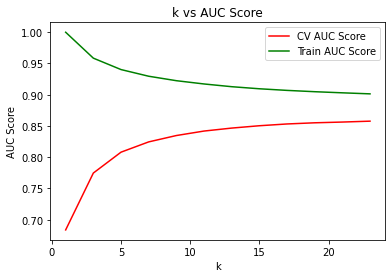

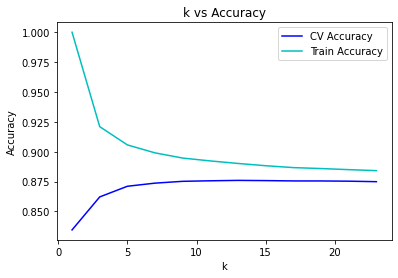

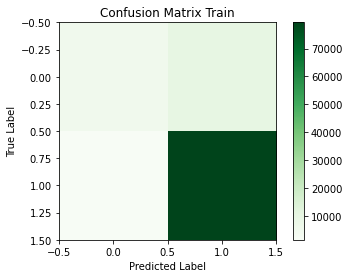

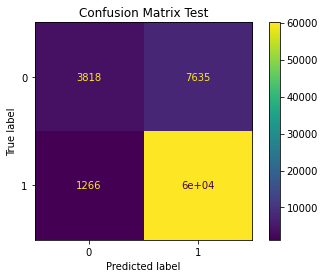

257296    1
475038    1
533789    1
333345    1
2166      1
         ..
326993    1
393602    0
176000    1
563994    0
170857    1
Name: Review, Length: 72767, dtype: int32 

[1.         0.95652174 0.86956522 ... 0.91304348 0.60869565 0.7826087 ] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.8652712279105005
Accuracy (Test): 0.877678068355161


In [79]:
auc_score_word2vec_test, accuracy_bword2vec_test = KNN_train_simple_cv(X_train_tfidf_word2vec, Y_train_tfidf_wor2vec, X_test_tfidf_word2vec, Y_test_tfidf_wor2vec)

In [85]:
np.min(X_train_tfidf_word2vec)

-0.5025431893675845